### SET UP AND VARIABLE DEFINITONS

In [116]:
## set up
import io
import requests
import pandas as pd
import numpy as np
from typing import Tuple
import seaborn as sns
import pandas as pd
from pandas import DataFrame
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from pandas import DataFrame
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, MultiTaskLassoCV
from sklearn import tree
import matplotlib.pyplot as plt
pd.options.display.max_columns = 50
pd.options.display.max_rows = 50
import helper_functions.spreadsheet_specific_helpers as helper
import importlib
importlib.reload(helper)

<module 'helper_functions.spreadsheet_specific_helpers' from 'c:\\kelly\\School\\Colleage\\24-25\\seal\\gamification_data_analysis\\helper_functions\\spreadsheet_specific_helpers.py'>

In [31]:
SHEETURL: str = (
    "https://docs.google.com/spreadsheets/d/"
    "1XcR48HZuC-mSFB-uKIxwPFhfRGVX7bWy100PhcLA8oM/"
    "edit?resourcekey=&gid=1780925762#gid=1780925762"
)

# format for CSV https://docs.google.com/spreadsheets/d/
# <SHEET_ID>/gviz/tq?tqx=
# out:csv&sheet=<SHEET_NAME>
SHEET_CSV_URL: str = (
    "https://docs.google.com/spreadsheets/d/"
    "1XcR48HZuC-mSFB-uKIxwPFhfRGVX7bWy100PhcLA8oM/"
    "gviz/tq?tqx=out:csv&sheet=Congregated Data"
)

RANDOM_SEED = 12

In [32]:

# global variables for our current data purposes
Y_COLS = [
    "On a scale of 1 - 5 how successful do you feel you are in SEAL lab?",
    "On a scale of 1 - 5, how successful to do you feel your teammates are in SEAL lab?",
    "On a scale of 1 - 5, how successful do your peers think you are in SEAL lab?",
    "On whole, how would you rate your satisfaction in SEAL lab?"
]

X_DEMO_COLS = [
    "Main SEAL group affiliation",
    "Age",
    "Gender",
    "Sexual orientation",
    "Race",
    "Chronic condition",
    "Condition description",
    "Economic class",
    "Religion"
]

X_PERSONALITY_COLS = [
    "Internal / External game motivation",
    "[Introverted - Extroverted]",
    "[Critical - Trusting]",
    "[Spontaneous - Conscientious]",
    "[Self-conscious - Even-tempered]",
    "[Prefer similarity - Am open to change]"
]
MOTIVATION_COLS = [
    "Beating my competitors",
    "Mastering the game",
    "Earning the most points",
    "Working with a team",
    "Feeling immersed in the story/plot"
]

X_SEAL_COLS = [
    "I feel like I am playing a game",
    "I consider myself to be highly experienced.",
    "Aesthetically pleasing.",
    "Rank reflects work accurately.",
    "Leaderboard reflects work accurately.",
    "YBR reflects work accurately.",
    "VisTools reflects work accurately.",
    "RaceTrack reflects work accurately.",
    "Battle Station reflects work accurately.",
    "Command Center reflects work accurately.",
    "I understand what my SEAL statistics mean.",
    "I know exactly how my actions affect my lab statistics",
    "Using the Sudoku Sheet Tools helps me and my team stay on track.",
    "Using the Sudoku Sheet Tools encourages me to take risks and challenge myself.",
    "Using the Sudoku Sheet Tools makes my work in SEAL more enjoyable."
]
# AO:AX
X_USABILITY_COLS = [
    'I think that I would like to use this system frequently',
    'I found the system unnecessarily complex',
    'I thought the system was easy to use',
    'I think that I would need the support of a technical person to be able to use this system',
    'I found the various functions in this system were well integrated',
    'I thought there was too much inconsistency in this system',
    'I would imagine that most people would learn to use this system very quickly',
    'I found the system very cumbersome to use',
    'I felt very confident using the system',
    'I needed to learn a lot of things before I could get going with this system.',
    'SUS Overall Score', 'Learnability subscore', 'Usability subscore']

Y_COLS = ["Personal success",
          "Teammate success",
          "Peer success",
          "Satisfaction in SEAL"
]

X_DROP_COLS = ['All SEAL group affiliations', 'Game motivation']

### Extract the data

In [33]:
def get_data() -> DataFrame:  # idealy we dont want to us Any, but for now
    """function to get the data from the google sheet
    raises: HTTPError: if the request fails (meaning url wrong or no inter)

    @returns: @type(DataFrame): the data from the google sheet"""

    response = requests.get(SHEET_CSV_URL)
    response.raise_for_status()  # Raise error if request fails
    df: DataFrame = pd.read_csv(io.StringIO(response.text))
    return df

In [34]:
## ORIGINAL
data = get_data()
columns = data.columns
print(columns)
print(data.shape) # 81 x 50


Index(['Main SEAL group affiliation', 'All SEAL group affiliations',
       'Developed for SUDOKU Sheet Tools?', 'Age', 'Gender',
       'Sexual orientation', 'Race', 'Chronic condition',
       'Condition description', 'Economic class', 'Religion',
       'Game motivation', 'Internal / External game motivation',
       '[Introverted - Extroverted]', '[Critical - Trusting]',
       '[Spontaneous - Conscientious]', '[Self-conscious - Even-tempered]',
       '[Prefer similarity - Am open to change]',
       'I feel like I am playing a game',
       'I consider myself to be highly experienced.',
       'Aesthetically pleasing.', 'Rank reflects work accurately.',
       'Leaderboard reflects work accurately.',
       'YBR reflects work accurately.', 'VisTools reflects work accurately.',
       'RaceTrack reflects work accurately.',
       'Battle Station reflects work accurately.',
       'Command Center reflects work accurately.',
       'I understand what my SEAL statistics mean.',
     

In [44]:
def split_xy(data) -> Tuple[DataFrame, DataFrame]:
    """function to split the x and y data into separate ndarrays based on
    a set of columns to be dropped

    @parameter: data @type(DataFrame): rawdata

    @returns: @type(ndarray): relevant x-values from data
    @returns: @type(ndarray): y-values from data"""
    
    split_col: DataFrame = helper.split_motivation_column(data)
    x_data = data.drop(columns=X_DROP_COLS + Y_COLS)    # split motivation columns
    x_data = pd.concat([x_data, split_col], axis=1)

    # handle X_SEAL_COLS: map disagree - agree as 1-5
    options_map = {'Strongly disagree': 1,
                    'Disagree': 2,
                    'Neutral': 3,
                    'Agree': 4,
                    'Strongly agree': 5
                    }
    x_data[X_SEAL_COLS] = x_data[X_SEAL_COLS].replace(options_map)

    # Remove 'No response' features from demographic
    remove_vals = ['No response', 'Prefer not to answer','N/A']
    x_data[X_DEMO_COLS] = x_data[X_DEMO_COLS].replace(remove_vals, pd.NA)

    # Handle NaNs with data imputation of average
    x_data[X_PERSONALITY_COLS[1:]] = x_data[X_PERSONALITY_COLS[1:]].fillna(3)
    x_data[X_SEAL_COLS] = x_data[X_SEAL_COLS].fillna(3)
    x_data[X_USABILITY_COLS] = x_data[X_USABILITY_COLS].fillna(3)
    data[Y_COLS] = data[Y_COLS].fillna(3)

    # one-hot-encoding for categorical data (demographics, gaming)
    cat_col = x_data.select_dtypes(include=['object', 'category']).columns
    x_data = pd.get_dummies(x_data, columns = cat_col, drop_first=False)

    # filter low-frequency categories and remove non-contributing responses
    min_freq= 0.05 # 5% of data set
    freq = x_data.sum(axis=0) / len(x_data)
    filter_x = freq[freq > min_freq].index
    x_data = x_data[filter_x]
    regex = '|'.join(remove_vals)
    x_data = x_data.loc[:, ~x_data.columns.str.contains(regex, case=False, regex=True)]

    y_data = data[Y_COLS]
    return x_data, y_data

In [36]:
def standardize(x_train, x_test) -> Tuple[DataFrame, DataFrame]:
    """function that standardizes data to normal gaussian distribution.
    Standardization calculation is applied only to the training data.

    @parameter: x_train @type(nd.array) processed x training data to be standardized
    @paremeter: x_test @type(nd.array) processed x-test data to be standardized
    """
    scaler = StandardScaler().fit(x_train)  # only fit on training data
    x_train_stand = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns, index=x_train.index)
    x_test_stand = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns, index=x_test.index)
    return x_train_stand, x_test_stand

In [139]:
def inspect_correlation(data, title):
    """Generates heat map of given data set after being split."""
    corr = data.corr()

    threshold = 0.7
    # get all features that are highly correlated\
    #mask = (corr_x.abs() < threshold)
    #mask = mask & ~np.eye(mask.shape[0], dtype=bool)

    column_names =  [col[:5] for col in corr.columns]
    plt.figure(figsize=(14, 12))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)
    plt.title(title)
    plt.tight_layout()
    plt.show()



In [37]:
def plot_multitask_lasso_path(x_train, y_train):
    lasso_cv = MultiTaskLassoCV(alphas=np.logspace(-4, 0, 100), cv=5, random_state=RANDOM_SEED)
    lasso_cv.fit(x_train, y_train)

    # lasso_cv.coef_ is shape (n_targets, n_features)
    # To plot, we show coefficient magnitudes across alphas for each target separately

    alphas = lasso_cv.alphas_
    n_targets = y_train.shape[1]

    for task_idx in range(n_targets):
        coefs = []
        for alpha in alphas:
            lasso = MultiTaskLassoCV(alphas=[alpha], cv=5, random_state=RANDOM_SEED)
            lasso.fit(x_train, y_train)
            coefs.append(lasso.coef_[task_idx])

        coefs = np.array(coefs)
        plt.figure(figsize=(10, 5))
        for i in range(coefs.shape[1]):
            plt.plot(np.log10(alphas), coefs[:, i], label=x_train.columns[i])

        plt.xlabel("log10(alpha)")
        plt.ylabel(f"Coefficients (Target {task_idx+1})")
        plt.title(f"LASSO Path for Target {task_idx+1}")
        plt.grid(True)
        plt.tight_layout()
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
        plt.show()

In [68]:
def feature_selection(x_train, y_train):
    """function to apply LASSO regression on training data to select optimal
    features.

    @parameter: x_train @type(nd.array) standardized x_train data
    @parameter: y_train @type(nd.array) y_train data"""

    # perform 5-fold cross validation on lasso values
    lasso = MultiTaskLassoCV(alphas=np.logspace(-4, 0, 100), cv=5, random_state=RANDOM_SEED)
    lasso.fit(x_train, y_train)
    best_l1 = lasso.alpha_
    non_zero_indices = np.abs(lasso.coef_) >= 1e-8

    top_features = []
    eliminated_features = []

    for i, feature in enumerate(x_train.columns):
        if np.any(non_zero_indices[:, i]):
            top_features.append(feature)
        else:
            eliminated_features.append(feature)
    return x_train[top_features], best_l1, eliminated_features, top_features


In [ ]:

def linear_regression(x_train, y_train, x_test, y_test):
    """function to perform linear regression and calculate train and validation rmse
    via cross validation

    @parameter: x_train @type(nd.array) processed x_train data
    @parameter: y_train @type(nd.array) y_train data
    @returns: models @type(nd.array) linear regression models
    @returns: val_rmse @type(nd.array) validation rmses"""
    models = []
    val_rmse = []
    train_rmse = []
    test_rmse = []
    for i in range(y_train.shape[1]):
        y_t = y_train.iloc[:,i]
        y_test_i = y_test.iloc[:,i]
        model = LinearRegression()
        cv = KFold(n_splits = 5, shuffle=True, random_state = RANDOM_SEED)

        scores = cross_val_score(model, x_train, y_t, cv=cv, scoring='neg_mean_squared_error')
        v_rmse = np.sqrt(-scores.mean())
        val_rmse.append(v_rmse)

        #fit model for coefficients
        model.fit(x_train, y_t)
        models.append(model)

        # training error
        y_train_pred = model.predict(x_train)
        t_rmse = np.sqrt(mean_squared_error(y_t, y_train_pred))
        train_rmse.append(t_rmse)

        #testing error
        y_test_pred = model.predict(x_test)
        test_score = np.sqrt(mean_squared_error(y_test_i, y_test_pred))
        test_rmse.append(test_score)
        
    linear_visualization(models, x_train.columns, y_train.columns, train_rmse, val_rmse, test_rmse)
    return models, val_rmse

def linear_visualization(models, features, y_cols, train_rmse, val_rmse, test_rmse):
    """function to visualize weights of top k coefficients of list of models
    """
    for i, model in enumerate(models):
        print(Y_COLS[i])
        
        coef = model.coef_
        coef_list = pd.DataFrame({"Feature": features, "Coef": coef})
        coef_list["abs"] = coef_list["Coef"].abs()
        top = coef_list.nlargest(len(coef_list), "abs")
        print(top[["Feature","Coef"]])

        plt.figure(figsize = (10,5))
        plt.barh(top["Feature"], top["Coef"])
        plt.xticks(rotation=45, ha="right")
        plt.xlabel("Features")
        plt.ylabel("Coef values")
        plt.title(f"{y_cols[i]}")
        plt.show()

    # separate model training and validation rmses
    x = np.arange(len(Y_COLS))
    width = 0.25

    fig, ax = plt.subplots(figsize=(8, 5))
    bars1 = ax.bar(x - width, train_rmse, width, label='Train RMSE')
    bars2 = ax.bar(x, val_rmse, width, label='Validation RMSE')
    bars3 = ax.bar(x + width, test_rmse, width, label='Test RMSE')

    ax.set_ylabel('RMSE')
    ax.set_title('Training vs Validation vs Test RMSE for Linear Regression')
    ax.set_xticks(x)
    ax.set_xticklabels(Y_COLS)
    ax.legend()

    for bar in bars1 + bars2 + bars3:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    

In [165]:
# decision tree for individual parameters per tree
def decision_tree(x_train, y_train, x_test, y_test):
    """Function to classify success as decision tree"""
    best_models = []
    train_rmses = []
    test_rmses = []
    best_params = []

    parameters = {
    'max_depth': np.arange(2,10,1),
    'min_samples_leaf': [1,2,4,6],
    'min_samples_split': [2,5,7,10]
    }
    

    for i in range(y_train.shape[1]):
        y_tr = y_train.iloc[:,i]
        y_te = y_test.iloc[:,i]
        model = tree.DecisionTreeRegressor(random_state=RANDOM_SEED)
        grid = GridSearchCV(model, param_grid=parameters, cv=5, scoring='neg_mean_squared_error')
        grid.fit(x_train, y_tr)

        best_model = grid.best_estimator_
        best_param = grid.best_params_
        best_models.append(best_model)
        best_params.append(best_param)
 
        y_train_pred = best_model.predict(x_train)
        train_rmse = np.sqrt(mean_squared_error(y_train_pred,y_tr))
        train_rmses.append(train_rmse)
        y_test_pred = best_model.predict(x_test)
        test_rmse = np.sqrt(mean_squared_error(y_te, y_test_pred))
        test_rmses.append(test_rmse)

        print("Best parameters:", best_param)
    return best_models, train_rmses, test_rmses, best_params

def tree_visualize(models, features, y_vals, train_rmses, test_rmses):
    for i, model in enumerate(models):
        print(f"{Y_COLS[i]} trainRMSE: {train_rmses[i]:.2f} testRMSE: {test_rmses[i]:.2f}")
        print(f"Depth of tree for {y_vals[i]}: {model.get_depth()}")
        if model.get_depth() > 3:
            plt.figure(figsize=(20, 12)) 
        else:  
            plt.figure(figsize=(12, 8))
        tree.plot_tree(model, feature_names= features, filled = True, fontsize= 10)
        plt.title(f"Decision tree for {y_vals[i]} [1-5]")
        plt.tight_layout()
        
        plt.show()

In [ ]:
def decision_tree(x_train, y_train, x_test, y_test):
    """Function to classify success as decision tree"""
    parameters = {
    'estimator__max_depth': np.arange(2,20,2),
    'estimator__min_samples_leaf': np.arange(5, 40, 5),
    'estimator__min_samples_split': np.arange(5,40,5)
    }
    
    model = tree.DecisionTreeRegressor(random_state=RANDOM_SEED)
    multi_tree = MultiOutputRegressor(model)

    #grid search with CV
    grid = GridSearchCV(multi_tree, param_grid=parameters, cv=5, scoring='neg_mean_squared_error')
    grid.fit(x_train,y_train)
    
    best_model = grid.best_estimator_
    best_param = grid.best_params_

    y_train_pred = best_model.predict(x_train)
    train_rmse = np.sqrt(mean_squared_error(y_train_pred,y_train))
    y_test_pred = best_model.predict(x_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    print("Best parameters:", best_param)
    return best_model, train_rmse, test_rmse

def tree_visualize(model, features, y_vals):
    for i, estimator in enumerate(model.estimators_):
        plt.figure(figsize=(16,8))
        tree.plot_tree(estimator, feature_names= features, filled = True, max_depth = 10, fontsize= 10)
        plt.title(f"Decision tree for {y_vals[i]}")
        plt.tight_layout
        plt.show()

C:\Users\kelly\AppData\Local\Temp\ipykernel_11184\305309105.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x_data[X_SEAL_COLS] = x_data[X_SEAL_COLS].replace(options_map)


(64, 62) (64, 4)
(17, 62) (17, 4)
(64, 62)
NaN values 0 0
0.24770763559917114
eliminated 50 ['[Introverted - Extroverted]', '[Critical - Trusting]', '[Spontaneous - Conscientious]', '[Prefer similarity - Am open to change]', 'I feel like I am playing a game', 'Aesthetically pleasing.', 'Rank reflects work accurately.', 'Leaderboard reflects work accurately.', 'VisTools reflects work accurately.', 'RaceTrack reflects work accurately.', 'Battle Station reflects work accurately.', 'Command Center reflects work accurately.', 'I understand what my SEAL statistics mean.', 'I know exactly how my actions affect my lab statistics', 'Using the Sudoku Sheet Tools helps me and my team stay on track.', 'Using the Sudoku Sheet Tools encourages me to take risks and challenge myself.', 'Using the Sudoku Sheet Tools makes my work in SEAL more enjoyable.', 'I found the system unnecessarily complex', 'I thought the system was easy to use', 'I think that I would need the support of a technical person to b

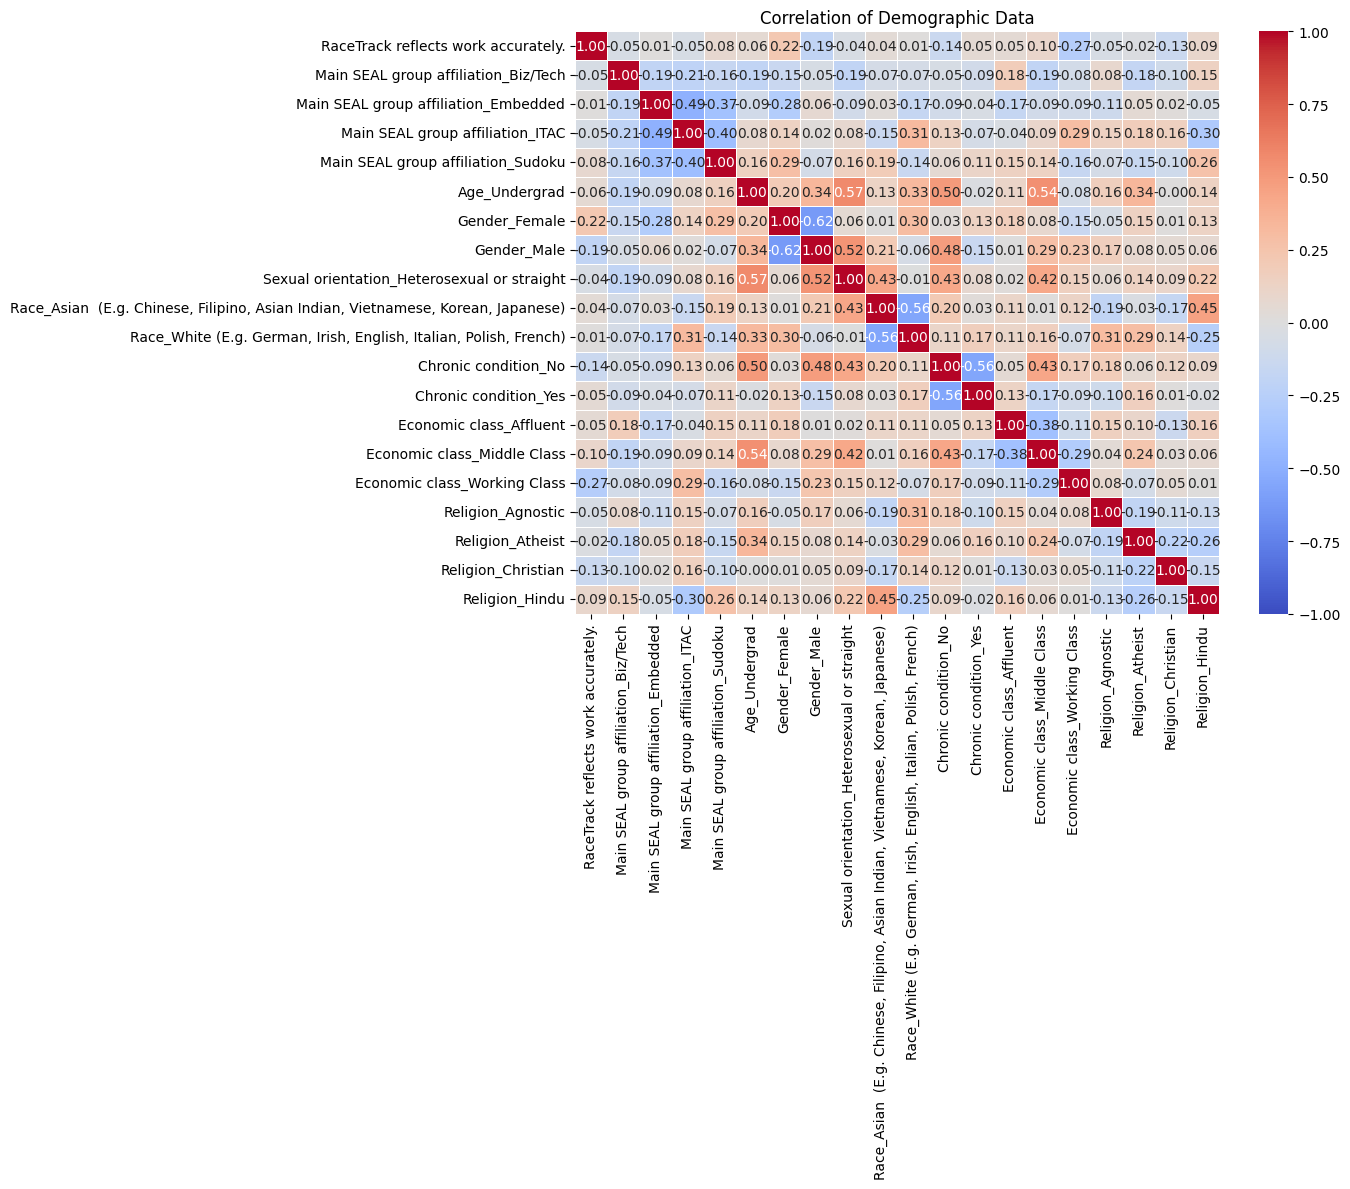

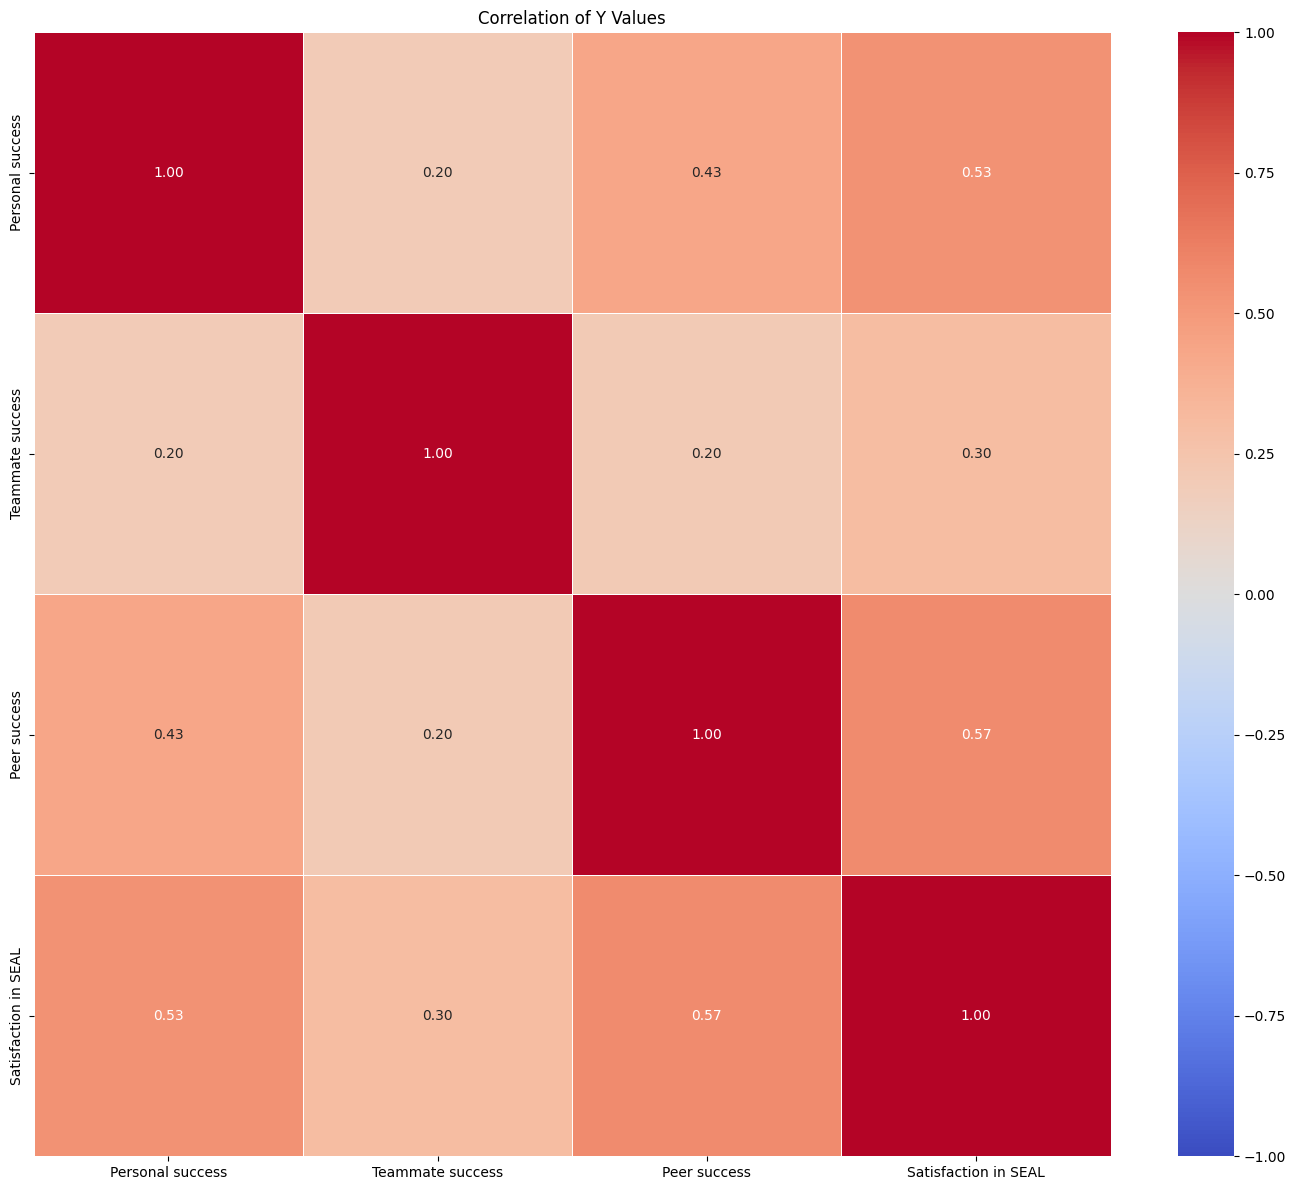

In [152]:
x_data, y_data = split_xy(data)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state = RANDOM_SEED)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

x_train, x_test = standardize(x_train, x_test)
x_features = x_train.columns
#y1, y2, y3, y4 = [y_data.iloc[:, i] for i in range(y_data.shape[1])]
print(x_train.shape)
x_nan = x_train.isna().sum().sum()
y_nan = x_train.isna().sum().sum()
print("NaN values", x_nan, y_nan)

x_train_reduced, l1, eliminated_features, top_features = feature_selection(x_train, y_train)
print(l1)
print(f'eliminated {len(eliminated_features)} {eliminated_features}')
print(f'kept {len(top_features)} {top_features}')
x_test_reduced = x_test[top_features]

demo_processed = x_data.loc[:, x_data.columns.str.contains('|'.join(X_DEMO_COLS))]

inspect_correlation(demo_processed, "Correlation of Demographic Data")
inspect_correlation(y_data, "Correlation of Y Values")

Personal success
                                              Feature      Coef
0                    [Self-conscious - Even-tempered]  0.246925
3   I think that I would like to use this system f...  0.212713
9                                         Gender_Male  0.210106
1         I consider myself to be highly experienced.  0.154237
8               Developed for SUDOKU Sheet Tools?_Yes  0.127819
6                    Main SEAL group affiliation_ITAC -0.107929
4              I felt very confident using the system  0.102095
2                       YBR reflects work accurately.  0.098448
5                                 Working with a team -0.070406
11                                 Religion_Christian -0.052296
10                              Chronic condition_Yes -0.044693
7                  Main SEAL group affiliation_Sudoku  0.032706


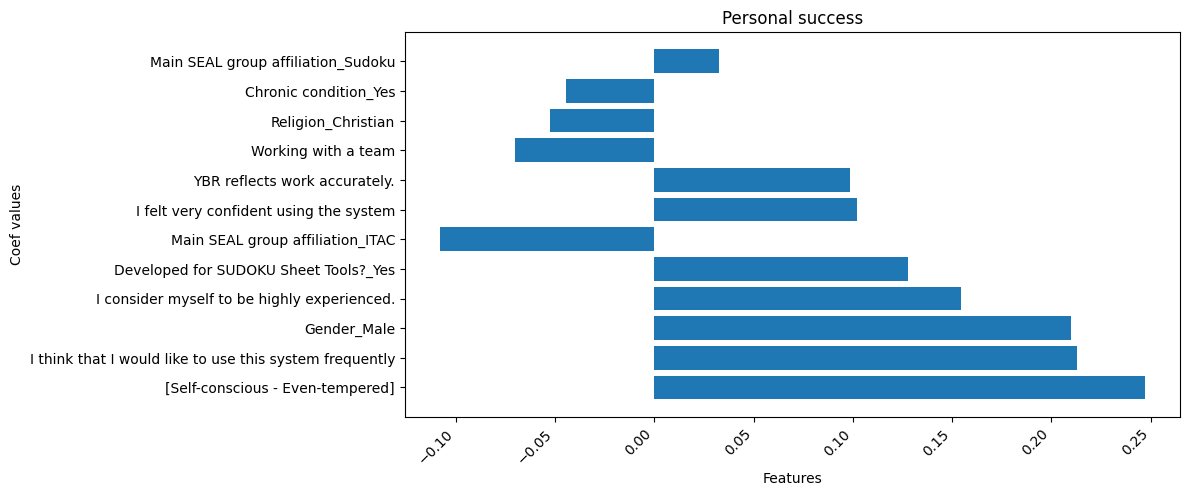

Teammate success
                                              Feature      Coef
2                       YBR reflects work accurately.  0.254260
11                                 Religion_Christian -0.248653
10                              Chronic condition_Yes  0.247666
7                  Main SEAL group affiliation_Sudoku  0.242487
4              I felt very confident using the system  0.229678
0                    [Self-conscious - Even-tempered] -0.155933
9                                         Gender_Male  0.096120
5                                 Working with a team -0.094441
1         I consider myself to be highly experienced. -0.074338
3   I think that I would like to use this system f... -0.066249
6                    Main SEAL group affiliation_ITAC  0.062250
8               Developed for SUDOKU Sheet Tools?_Yes  0.034583


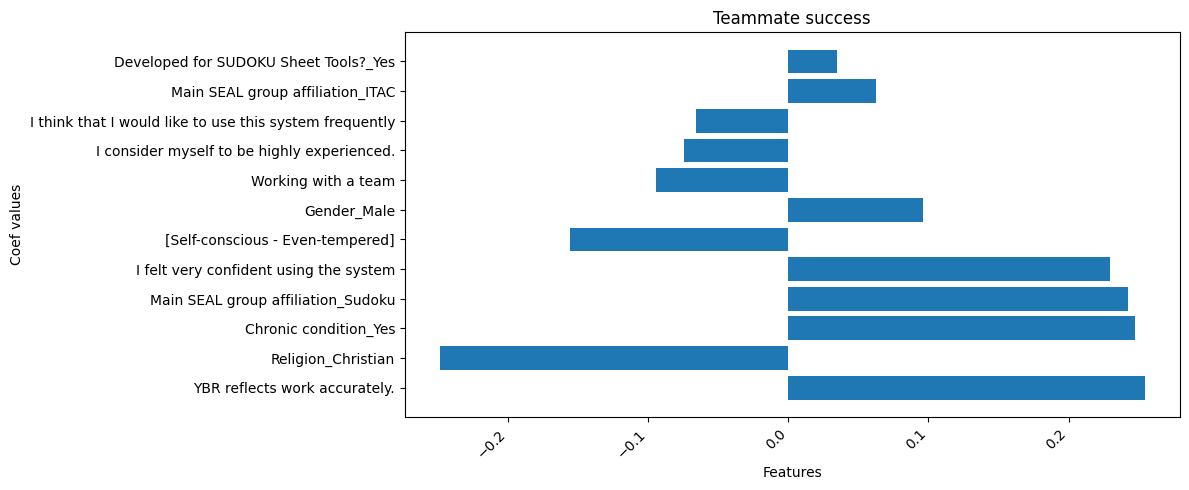

Peer success
                                              Feature      Coef
1         I consider myself to be highly experienced.  0.304564
4              I felt very confident using the system  0.191703
5                                 Working with a team  0.157720
11                                 Religion_Christian -0.152606
8               Developed for SUDOKU Sheet Tools?_Yes  0.125886
7                  Main SEAL group affiliation_Sudoku -0.091765
9                                         Gender_Male  0.082121
0                    [Self-conscious - Even-tempered]  0.080023
2                       YBR reflects work accurately.  0.069803
10                              Chronic condition_Yes -0.045054
6                    Main SEAL group affiliation_ITAC -0.014961
3   I think that I would like to use this system f...  0.013459


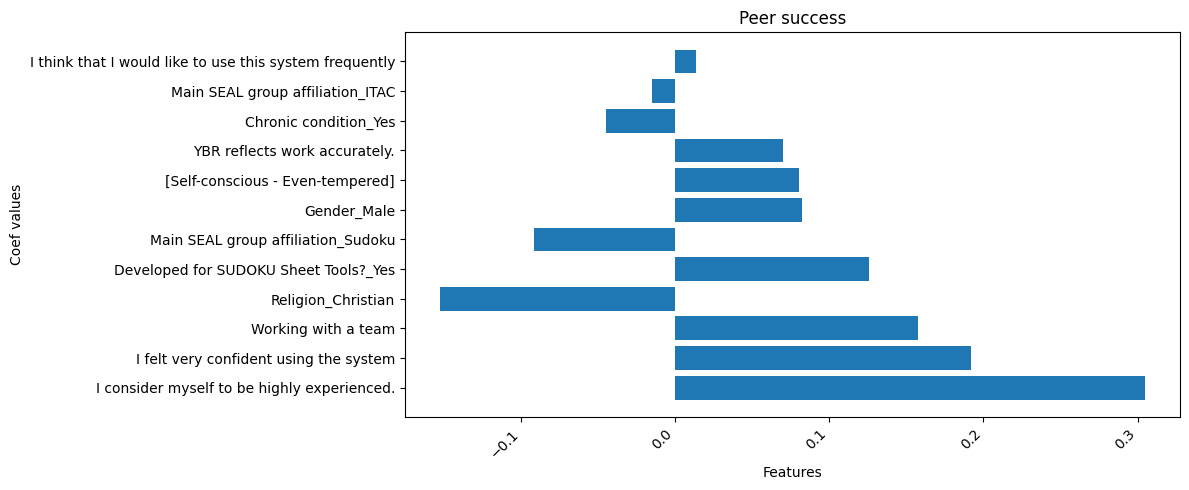

Satisfaction in SEAL
                                              Feature      Coef
2                       YBR reflects work accurately.  0.226531
4              I felt very confident using the system  0.198722
6                    Main SEAL group affiliation_ITAC -0.193119
1         I consider myself to be highly experienced.  0.189787
9                                         Gender_Male  0.147264
10                              Chronic condition_Yes  0.142061
5                                 Working with a team  0.130486
3   I think that I would like to use this system f...  0.124576
7                  Main SEAL group affiliation_Sudoku -0.103372
8               Developed for SUDOKU Sheet Tools?_Yes  0.084786
0                    [Self-conscious - Even-tempered]  0.049181
11                                 Religion_Christian -0.047494


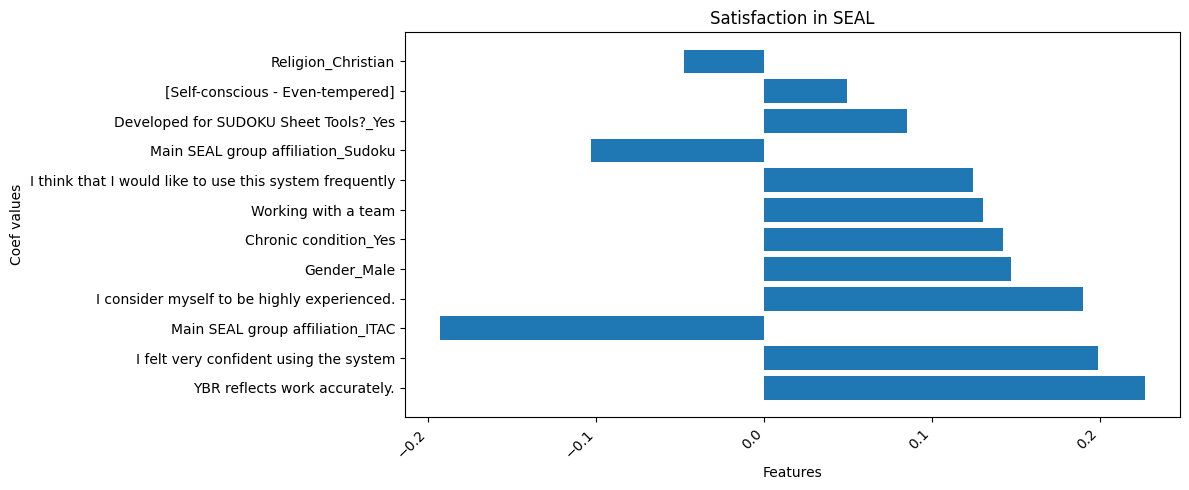

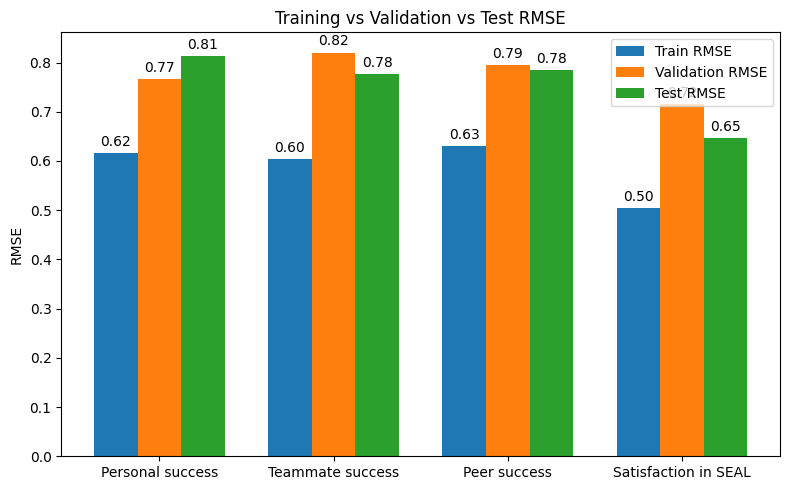

Best parameters: {'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best parameters: {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best parameters: {'max_depth': 2, 'min_samples_leaf': 6, 'min_samples_split': 2}
Best parameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10}
Personal success trainRMSE: 0.56 testRMSE: 0.95
Depth of tree for Personal success: 4


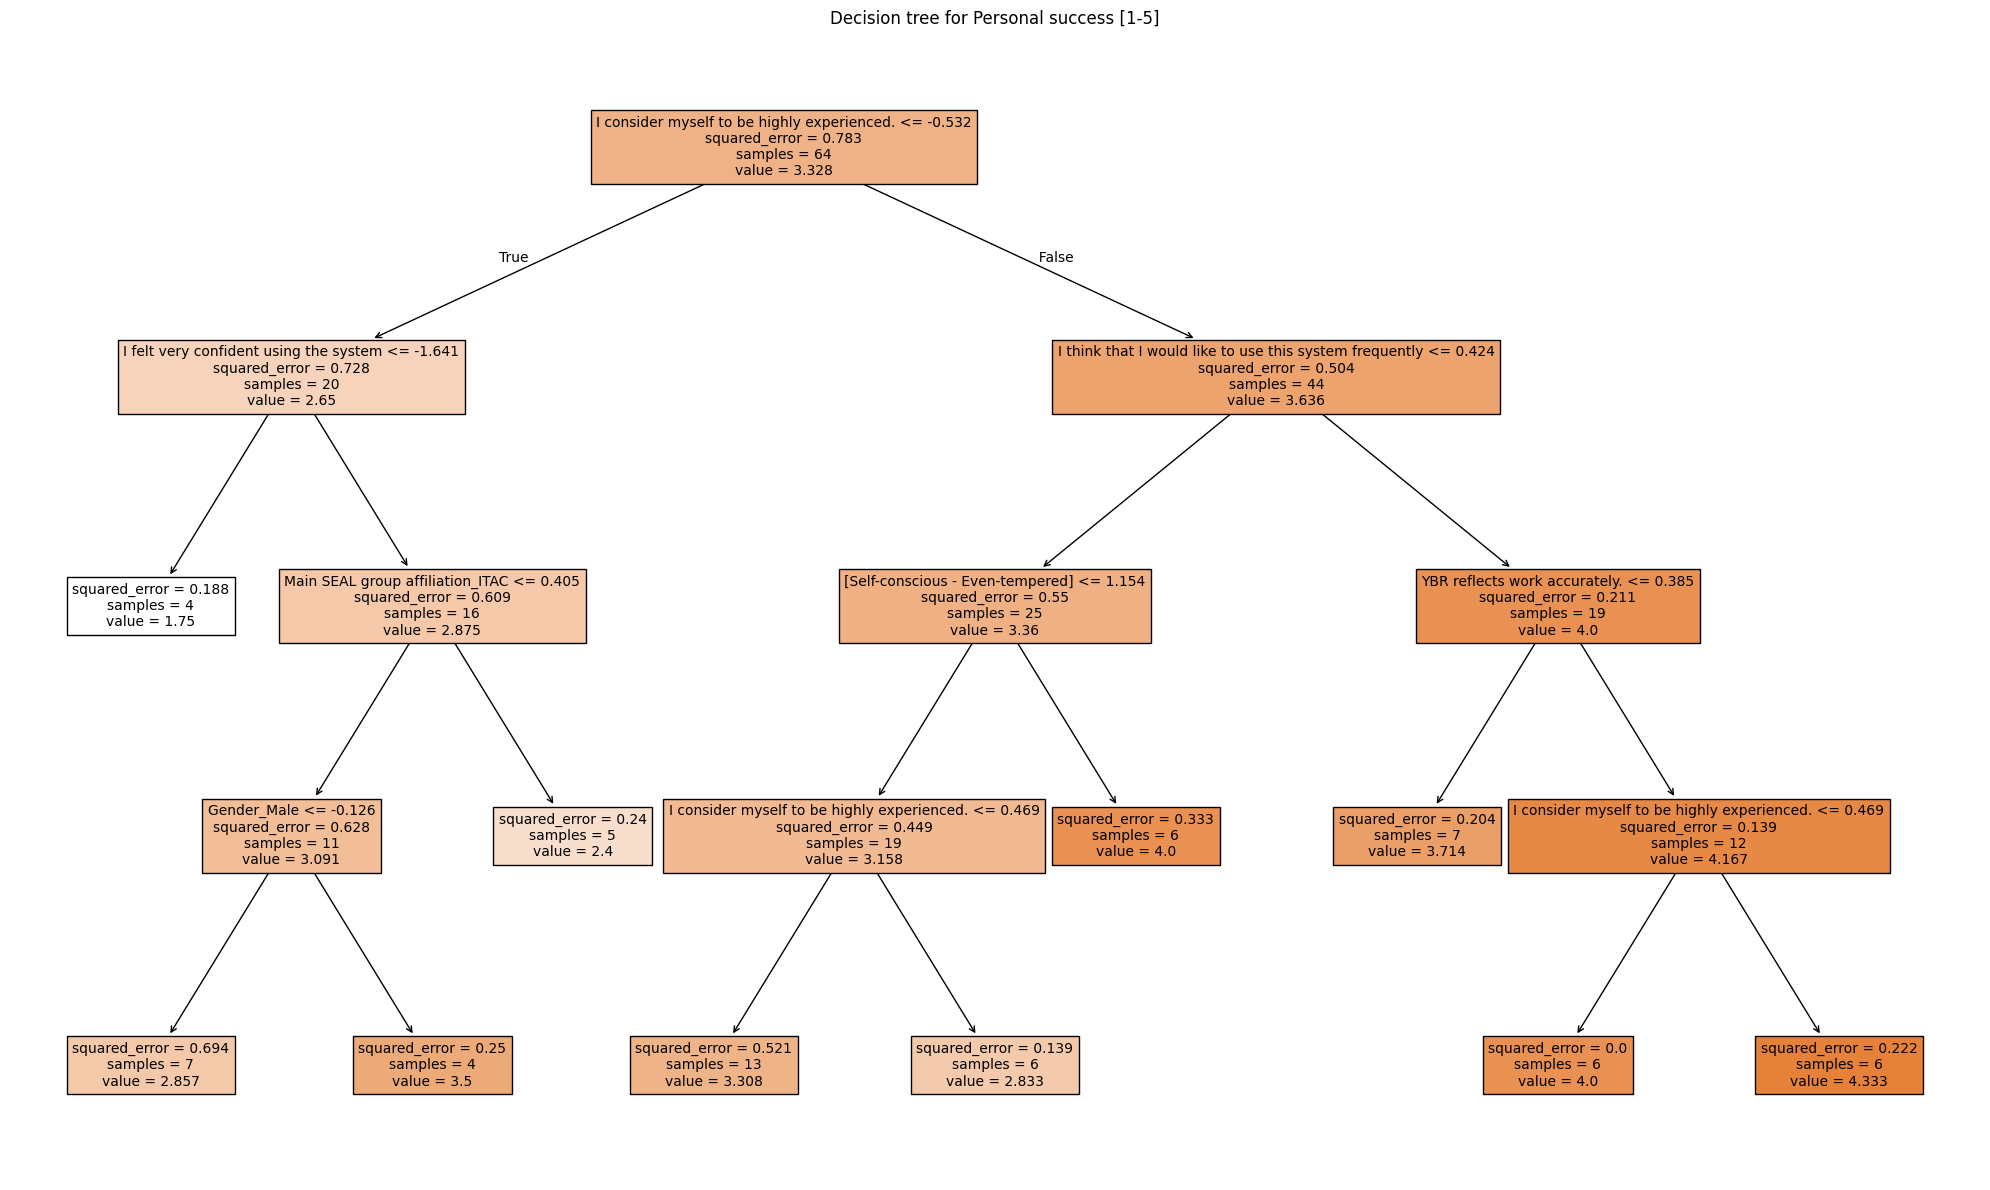

Teammate success trainRMSE: 0.71 testRMSE: 0.55
Depth of tree for Teammate success: 2


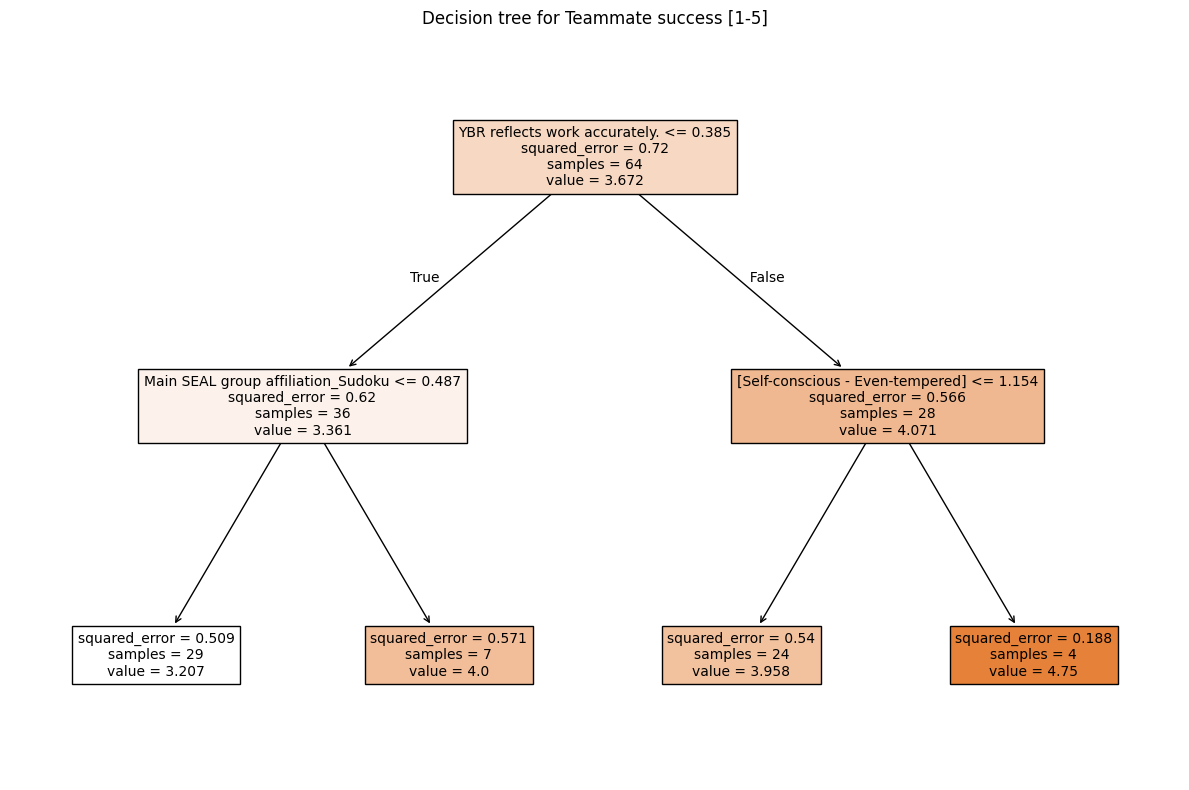

Peer success trainRMSE: 0.72 testRMSE: 0.86
Depth of tree for Peer success: 2


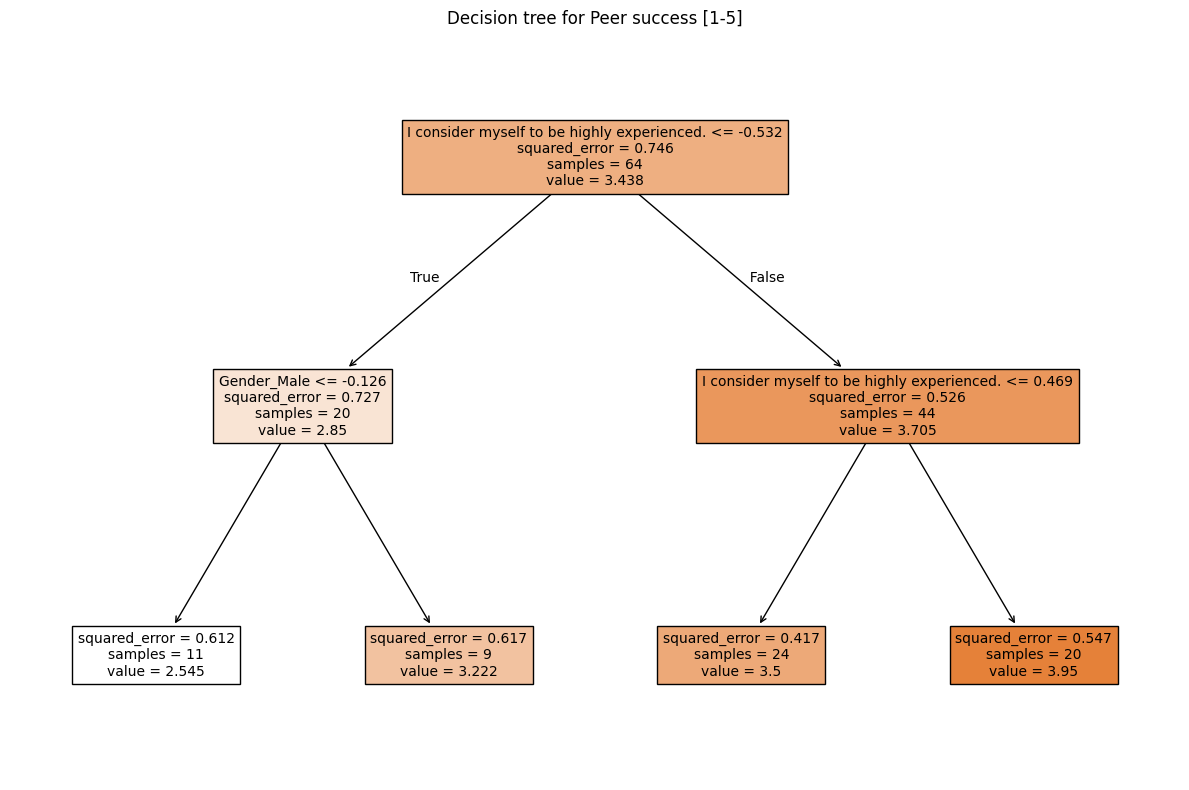

Satisfaction in SEAL trainRMSE: 0.60 testRMSE: 0.81
Depth of tree for Satisfaction in SEAL: 3


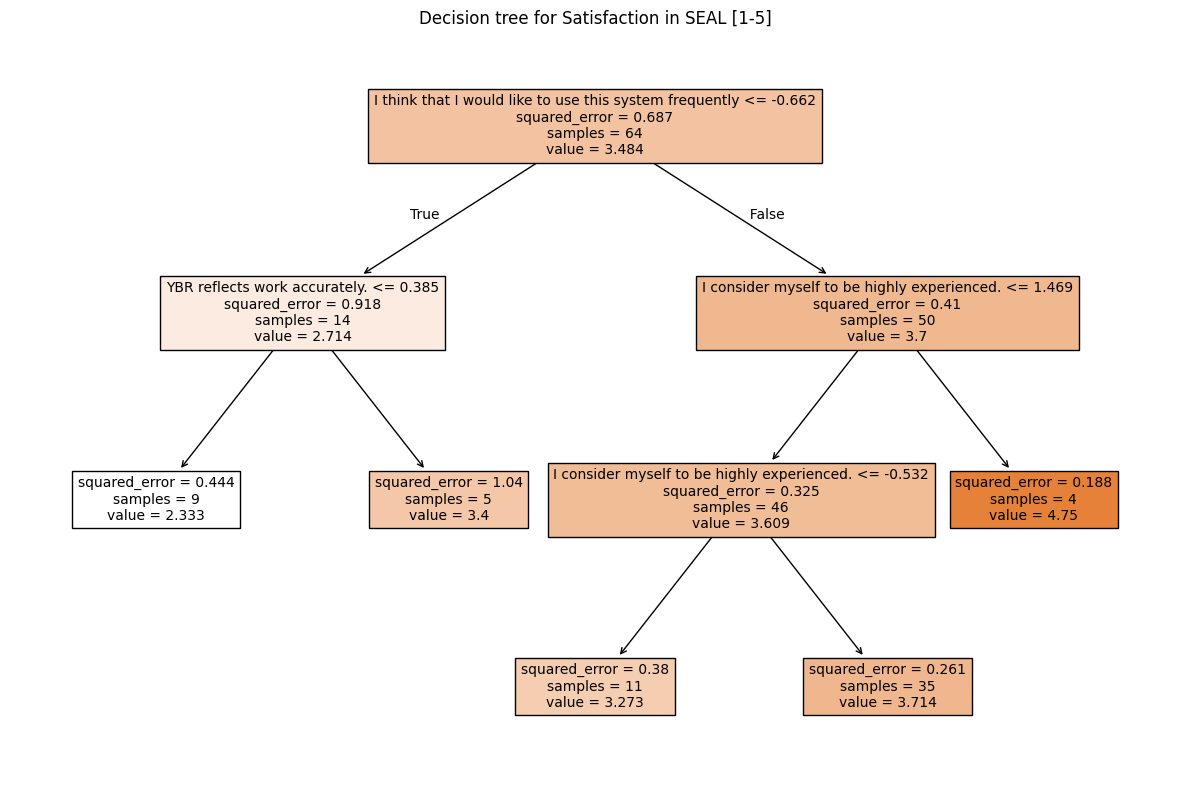

In [166]:
#plot_multitask_lasso_path(x_train, y_train)
models, lin_val_rmse = linear_regression(x_train_reduced,y_train, x_test_reduced, y_test)

# decision trees - uses non Lassoed data
best_models, train_rmses, test_rmses, best_params = decision_tree(x_train_reduced, y_train, x_test_reduced, y_test)
tree_visualize(best_models, top_features, Y_COLS, train_rmses, test_rmses)